In [ ]:
import os, shutil
import numpy as np
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
base_dir = 'tiles'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [2]:
import keras
from keras import layers
from keras import models
from keras.applications import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

img_width, img_height = 256, 256
conv_base= VGG16(weights='imagenet', include_top=False, input_shape=(img_width,img_height,3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(3072, activation='relu', init = 'he_normal')) #he_uniform
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3072, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Using TensorFlow backend.








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3072)              1575936   
_________________________________________________________________
dropout_1 (Dropout)          (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3072)              9440256   
_________________________________________________________________
dropout_2 (Dropout)          (None, 3072)              0         
_____________________

/home/miguelmmanso/anaconda3/envs/pruebas/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3072, activation="relu", kernel_initializer="he_normal")`
  


In [3]:
from keras import optimizers

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-5), metrics=['acc'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1. /255)
train_datagen = ImageDataGenerator(rescale=1. / 255, rotation_range=25, 
                                   width_shift_range=0.1, height_shift_range=0.1, 
                                   zoom_range=0.1, horizontal_flip=True, vertical_flip=True, 
                                   fill_mode='nearest')

#rescale=1. / 255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(256, 256),
                                                    batch_size=50, class_mode='binary')
validation_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(256, 256), 
                                                              batch_size=50,class_mode='binary')

Found 484048 images belonging to 2 classes.
Found 26893 images belonging to 2 classes.


In [5]:
train_steps_per_epoch = np.math.ceil(train_generator.samples / train_generator.batch_size)
validation_steps_per_epoch = np.math.ceil(validation_generator.samples / validation_generator.batch_size)

#teniendo en cuenta el desbalanceo de clases
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(train_generator.classes), train_generator.classes)
class_weights

/home/miguelmmanso/anaconda3/envs/pruebas/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


array([1.03952376, 0.96337163])

In [6]:
history = model.fit_generator(train_generator, steps_per_epoch= train_steps_per_epoch, 
                              epochs=40, validation_data=validation_generator,
                              validation_steps=validation_steps_per_epoch, class_weight=class_weights) #callbacks = [tensorboard]

Epoch 1/40
9681/9681 [==============================] - 5051s 522ms/step - loss: 0.3981 - acc: 0.8082 - val_loss: 0.3451 - val_acc: 0.8320
Epoch 2/40
9681/9681 [==============================] - 5030s 520ms/step - loss: 0.3513 - acc: 0.8269 - val_loss: 0.3392 - val_acc: 0.8350
Epoch 3/40
9681/9681 [==============================] - 5025s 519ms/step - loss: 0.3385 - acc: 0.8313 - val_loss: 0.3309 - val_acc: 0.8362
Epoch 4/40
9681/9681 [==============================] - 4985s 515ms/step - loss: 0.3306 - acc: 0.8348 - val_loss: 0.3377 - val_acc: 0.8369
Epoch 5/40
9681/9681 [==============================] - 4963s 513ms/step - loss: 0.3247 - acc: 0.8368 - val_loss: 0.3153 - val_acc: 0.8393
Epoch 6/40
9681/9681 [==============================] - 4966s 513ms/step - loss: 0.3202 - acc: 0.8387 - val_loss: 0.3206 - val_acc: 0.8391
Epoch 7/40
9681/9681 [==============================] - 4965s 513ms/step - loss: 0.3160 - acc: 0.8406 - val_loss: 0.3213 - val_acc: 0.8352
Epoch 8/40
9681/9681 [=====

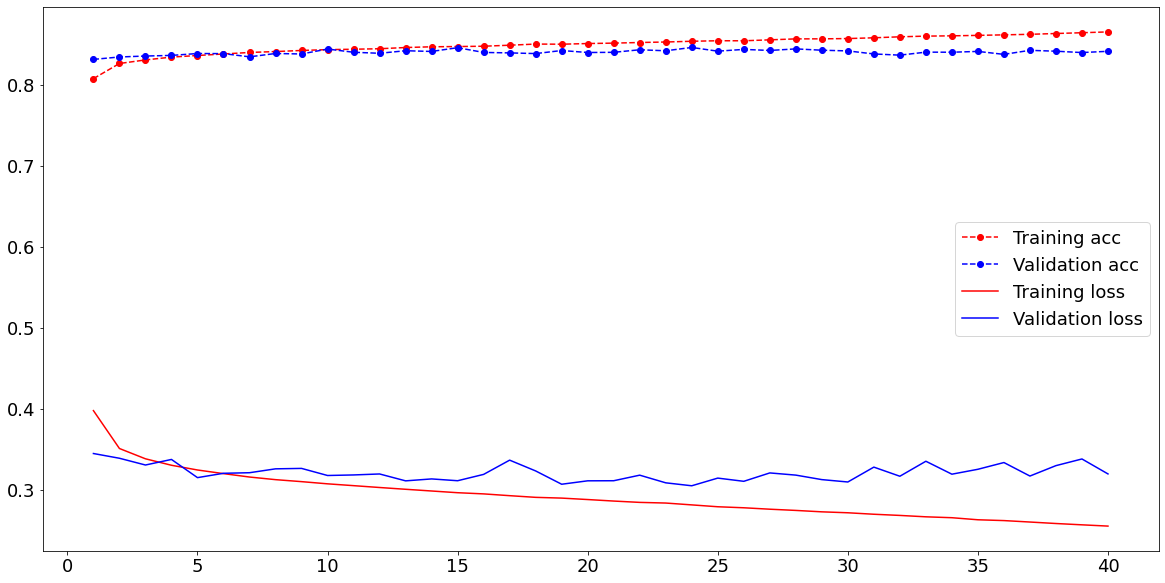

In [9]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.figure(figsize=(20,10))
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) +1) 
plt.plot(epochs, acc, 'bo--', color='r', label='Training acc')
plt.plot(epochs, val_acc, 'bo--', color='b', label='Validation acc')
plt.legend()
#plt.figure(figsize=(20,10))
plt.plot(epochs, loss, color= 'r', label='Training loss')
plt.plot(epochs, val_loss, color="b", label='Validation loss')
plt.legend()
plt.show()
plt.rcParams.update({'font.size':18})

In [8]:
model.save("Models1/VGG5-2.h5")